In [15]:
# Import libaries
import pandas as pd

#%% Read input data
# Input Data Reading
timeseries = pd.read_excel('../data/input_data_assignment2_2.xls', 
                           sheet_name='timeseries', 
                           index_col=[0], 
                           parse_dates=True)

# Add timestep (oemof model needs time increment)
timeseries.index.freq = '1H'

capacities = pd.read_excel('../data/input_data_assignment2_2.xls', 
                           sheet_name='capacity', 
                           index_col=[0], 
                           parse_dates=True)
tech = pd.read_excel('../data/input_data_assignment2_2.xls', 
                           sheet_name='tech', 
                           index_col=[0], 
                           parse_dates=True)
costs = pd.read_excel('../data/input_data_assignment2_2.xls', 
                           sheet_name='costs', 
                           index_col=[0], 
                           parse_dates=True)



/home/shahzaibkhn7/micromamba/envs/sustainable_energy/lib/python3.7/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/home/shahzaibkhn7/micromamba/envs/sustainable_energy/lib/python3.7/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


array([<AxesSubplot:xlabel='timeindex'>, <AxesSubplot:xlabel='timeindex'>,
       <AxesSubplot:xlabel='timeindex'>, <AxesSubplot:xlabel='timeindex'>,
       <AxesSubplot:xlabel='timeindex'>, <AxesSubplot:xlabel='timeindex'>,
       <AxesSubplot:xlabel='timeindex'>], dtype=object)

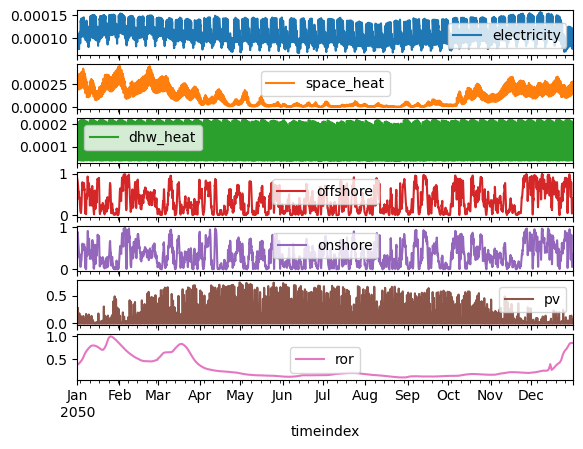

In [16]:
# Plot timeseries data
timeseries.plot(subplots=True)

In [17]:
# Load libaries
from oemof import solph
from oemof.tools import economics

import matplotlib.pyplot as plt
from collections import OrderedDict

#%% Initialize the energy system and read/calculate necessary parameters
energysystem_100 = solph.EnergySystem(timeindex=timeseries.index)

In [18]:
#%% Create oemof Buses

# create electricity bus
bus_electricity = solph.Bus(label='bus_electricity_l')
# create heat bus
bus_heat = solph.Bus(label='bus_heat_l')
# create biomass bus
bus_biomass = solph.Bus(label='bus_biomass_l')

# add buses to energy model
energysystem_100.add(bus_electricity, bus_heat, bus_biomass)

In [19]:
#%% Create oemof Sinks

# create excess component for the electricity bus to allow overproduction
electricity_excess = solph.Sink(label='electricty_excess_l', 
                                inputs={bus_electricity: solph.Flow()})

# create simple sink object representing the electrical demand
electricity_demand = solph.Sink(label='electricity_demand_l',
                                inputs={bus_electricity: solph.Flow(
                                        fix=timeseries['electricity'], 
                                        nominal_value=capacities['electricity']['amount'])})

# create excess component for the heat bus to allow overproduction
heat_excess = solph.Sink(label='heat_excess_l', 
                         inputs={bus_heat: solph.Flow()})

# create simple sink object representing the heat demand (space heat and hot water demand)
heat_space_demand = solph.Sink(label='heat_space_demand_l',
                               inputs={bus_heat: solph.Flow(
                                       fix=timeseries['space_heat'], 
                                       nominal_value=capacities['space_heat']['amount'])})

heat_dhw_demand = solph.Sink(label='heat_dhw_demand_l',
                             inputs={bus_heat: solph.Flow(
                                     fix=timeseries['dhw_heat'], 
                                     nominal_value=capacities['dhw_heat']['amount'])})

In [20]:
#%% Economic caluclation (for dispatch/sizing optimization) 

## Capital costs [€/MW(h)]
# Annuities [€/MW(h)/a]
a_onshore = economics.annuity(capex=costs['onshore']['capex'], 
                              n=costs['onshore']['lifetime'],
                              wacc=costs['onshore']['wacc'])
a_offshore = economics.annuity(capex=costs['offshore']['capex'], 
                               n=costs['offshore']['lifetime'],
                               wacc=costs['offshore']['wacc'])
a_pv = economics.annuity(capex=costs['pv']['capex'], 
                         n=costs['pv']['lifetime'],
                         wacc=costs['pv']['wacc'])
a_ror = economics.annuity(capex=costs['ror']['capex'], 
                          n=costs['ror']['lifetime'],
                          wacc=costs['ror']['wacc'])

a_chp = economics.annuity(capex=costs['chp']['capex'], 
                            n=costs['chp']['lifetime'],
                            wacc=costs['chp']['wacc'])
a_hp = economics.annuity(capex=costs['hp']['capex'], 
                           n=costs['hp']['lifetime'],
                           wacc=costs['hp']['wacc'])

a_battery_energy = economics.annuity(capex=costs['battery']['capex_energy'], 
                                     n=costs['battery']['lifetime'],
                                     wacc=costs['battery']['wacc'])
a_battery = economics.annuity(capex=costs['battery']['capex'], 
                              n=costs['battery']['lifetime'],
                              wacc=costs['battery']['wacc'])
a_hydrogen_energy = economics.annuity(capex=costs['hydrogen']['capex_energy'], 
                                      n=costs['hydrogen']['lifetime'],
                                      wacc=costs['hydrogen']['wacc'])
a_hydrogen = economics.annuity(capex=costs['hydrogen']['capex'], 
                               n=costs['hydrogen']['lifetime'],
                               wacc=costs['hydrogen']['wacc'])
a_acaes_energy = economics.annuity(capex=costs['acaes']['capex_energy'], 
                                     n=costs['acaes']['lifetime'],
                                     wacc=costs['acaes']['wacc'])
a_acaes = economics.annuity(capex=costs['acaes']['capex'], 
                              n=costs['acaes']['lifetime'],
                              wacc=costs['acaes']['wacc'])
a_tes_energy = economics.annuity(capex=costs['tes']['capex_energy'], 
                                   n=costs['tes']['lifetime'],
                                       wacc=costs['tes']['wacc'])


In [21]:
# Capital costs sum of annuities and fixed opex [€/MW(h)/a]
cc_onshore = (a_onshore + costs['onshore']['fom'])
cc_offshore = (a_offshore + costs['offshore']['fom'])
cc_pv = (a_pv + costs['pv']['fom'])
cc_ror = (a_ror + costs['ror']['fom'])

cc_chp = (a_chp + costs['chp']['fom'])
cc_hp = (a_hp + costs['hp']['fom'])

cc_battery_energy = (a_battery_energy + costs['battery']['fom'])
cc_battery = (a_battery)
cc_hydrogen_energy = (a_hydrogen_energy + costs['hydrogen']['fom'])
cc_hydrogen = (a_hydrogen)
cc_acaes_energy = (a_acaes_energy + costs['acaes']['fom'])
cc_acaes = (a_acaes)
cc_tes_energy = (a_tes_energy + costs['tes']['fom'])

In [22]:
## Marginal costs [€/MWh/a]
mc_onshore = costs['onshore']['vom']
mc_offshore = costs['offshore']['vom']
mc_pv = costs['pv']['vom']
mc_ror = costs['ror']['vom']

mc_chp = (costs['chp']['vom'])
mc_hp = costs['hp']['vom']

mc_battery = costs['battery']['vom']
mc_hydrogen = costs['hydrogen']['vom']
mc_acaes = costs['acaes']['vom']
mc_tes = costs['tes']['vom']

In [23]:
#%%Create oemof Sources

# create fixed source object representing wind power plants offshore
wind_offshore = solph.Source(label='wind_offshore_l',
                             outputs={bus_electricity: solph.Flow(   
                                     fix=timeseries['offshore'], 
                                     variable_costs=mc_offshore,
                                     investment=solph.Investment(
                                                ep_costs=cc_offshore,
                                                maximum=capacities['offshore']['capacity_potential'],
                                                existing=capacities['offshore']['capacity_existing']))
                                    },)

# create fixed source object representing wind power plants onshore
wind_onshore = solph.Source(label='wind_onshore_l',
                            outputs={bus_electricity: solph.Flow(
                                    fix=timeseries['onshore'], 
                                    variable_costs=mc_onshore,
                                    investment=solph.Investment(
                                               ep_costs=cc_onshore,
                                               maximum=capacities['onshore']['capacity_potential'],
                                               existing=capacities['onshore']['capacity_existing']))
                                    },)

# create fixed source object representing pv power plants
pv = solph.Source(label='pv_l',
                  outputs={bus_electricity: solph.Flow(
                           fix=timeseries['pv'], 
                           variable_costs=mc_pv,
                           investment=solph.Investment(
                                      ep_costs=cc_pv,
                                      maximum=capacities['pv']['capacity_potential'],
                                      existing=capacities['pv']['capacity_existing']))
                           },)

# create fixed source object representing hydro run of river plant
ror = solph.Source(label='ror_l',
                   outputs={bus_electricity: solph.Flow(
                            fix=timeseries['ror'], 
                            variable_costs=mc_ror,
                            investment=solph.Investment(
                                       ep_costs=cc_ror,
                                       maximum=capacities['ror']['capacity_potential'],
                                       existing=capacities['ror']['capacity_existing']))
                            },)

# create fixed source object representing biomass ressource
biomass = solph.Source(label='biomass_l',
                       outputs={bus_biomass: solph.Flow(
                               nominal_value=capacities['biomass']['capacity_potential'],
                               summed_max=1)
                               },)
                                   	

In [24]:
#%% Create oemof Storages

# create storage object representing a battery
battery = solph.components.GenericStorage(label='battery_l',
                                          inputs={bus_electricity: solph.Flow(
                                                  investment=solph.Investment(
                                                             ep_costs=cc_battery,
                                                             maximum=capacities['battery']['storage_power_potential']),
                                                  variable_costs=mc_battery)},
                                          outputs={bus_electricity: solph.Flow()},
                                          loss_rate=tech['battery']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech['battery']['max_hours'],
                                          invest_relation_output_capacity=1/tech['battery']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech['battery']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_battery_energy,
                                                     maximum=capacities['battery']['capacity_potential']),)

# create storage object representing a hydrogen
hydrogen = solph.components.GenericStorage(label='hydrogen_l',
                                          inputs={bus_electricity: solph.Flow(
                                                  investment=solph.Investment(
                                                             ep_costs=cc_hydrogen,
                                                             maximum=capacities['hydrogen']['storage_power_potential']),
                                                  variable_costs=mc_hydrogen)},
                                          outputs={bus_electricity: solph.Flow()},
                                          loss_rate=tech['hydrogen']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech['hydrogen']['max_hours'],
                                          invest_relation_output_capacity=1/tech['hydrogen']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech['hydrogen']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_hydrogen_energy,
                                                     maximum=capacities['hydrogen']['capacity_potential']),)

# create storage object representing a adiabatic compressed air energy storage (ACAES)
acaes = solph.components.GenericStorage(label='acaes_l',
                                          inputs={bus_electricity: solph.Flow(
                                                  investment=solph.Investment(
                                                             ep_costs=cc_acaes,
                                                             maximum=capacities['acaes']['storage_power_potential']),
                                                  variable_costs=mc_acaes)},
                                          outputs={bus_electricity: solph.Flow()},
                                          loss_rate=tech['acaes']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech['acaes']['max_hours'],
                                          invest_relation_output_capacity=1/tech['acaes']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech['acaes']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_acaes_energy,
                                                     maximum=capacities['acaes']['capacity_potential']),)

# create storage object representing a battery
tes = solph.components.GenericStorage(label='tes_l',
                                          inputs={bus_heat: solph.Flow(
                                                  investment=solph.Investment(
                                                             maximum=capacities['tes']['storage_power_potential']),
                                                  variable_costs=mc_tes)},
                                          outputs={bus_heat: solph.Flow()},
                                          loss_rate=tech['tes']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech['tes']['max_hours'],
                                          invest_relation_output_capacity=1/tech['tes']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech['tes']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_tes_energy,
                                                     maximum=capacities['tes']['capacity_potential']),)

In [25]:
#%% Create oemof Transormers

# create transformer object representing CHP plants
chp = solph.Transformer(label='chp_l',
                        inputs={bus_biomass: solph.Flow(
                                    variable_costs=mc_chp)},
                        outputs={bus_electricity: solph.Flow(
                                    investment=solph.Investment(
                                               ep_costs=cc_chp,
                                               existing=capacities['chp']['capacity_existing'])),
                                 bus_heat: solph.Flow()},
                        conversion_factors={bus_electricity: tech['chp']['electric_efficiency'],
                                            bus_heat: tech['chp']['thermal_efficiency']},
                        )

# create transformer object representing heat pumps
hp = solph.Transformer(label='hp_l',
                       inputs={bus_electricity: solph.Flow()},
                       outputs={bus_heat: solph.Flow(
                                investment=solph.Investment(
                                           ep_costs=cc_hp),
                                variable_costs=mc_hp)},
                       conversion_factors={bus_electricity: 1/tech['hp']['efficiency']},
                       )

In [26]:
#%% Add all components to the energysystem
energysystem_100.add(electricity_excess, electricity_demand,
                 heat_excess, heat_space_demand, heat_dhw_demand,
                 wind_offshore, wind_onshore, pv, ror, biomass,
                 battery, hydrogen, acaes, tes, 
                 hp, chp)

In [27]:
#%% Optimise the energy system

# initialise the operational model
om = solph.Model(energysystem_100)

# if tee_switch is true solver messages will be displayed
om.solve(solver='cbc')


{'Problem': [{'Name': 'unknown', 'Lower bound': 2490572856.0, 'Upper bound': 2490572856.0, 'Number of objectives': 1, 'Number of constraints': 245298, 'Number of variables': 210263, 'Number of nonzeros': 35047, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 335.79, 'Wallclock time': 336.77, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': None, 'Number of created subproblems': None}, 'Black box': {'Number of iterations': 82401}}, 'Error rc': 0, 'Time': 336.84851360321045}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [29]:
#Extract main results save results to dump (optional)
energysystem_100.results['main'] = solph.processing.results(om)
energysystem_100.dump('../results/dumps',
                  filename='model_100.oemof')

'Attributes dumped to: ../results/dumps/model_100.oemof'

In [30]:
#%% Extract results 

# Extract results dict
results = solph.processing.results(om)

# Extract component results
results_wind_offshore = solph.views.node(results, 'wind_offshore_l')
results_wind_onshore = solph.views.node(results, 'wind_onshore_l')
results_pv = solph.views.node(results, 'pv_l')
results_ror = solph.views.node(results, 'ror_l')

results_biomass = solph.views.node(results, 'bus_biomass_l')
results_chp = solph.views.node(results, 'chp_l')
results_hp = solph.views.node(results, 'hp_l')

results_battery = solph.views.node(results, 'battery_l')
results_hydrogen = solph.views.node(results, 'hydrogen_l')
results_acaes = solph.views.node(results, 'acaes_l')
results_tes = solph.views.node(results, 'tes_l')

# Extract bus results
results_electricity_bus = solph.views.node(results, 'bus_electricity_l')
results_heat_bus = solph.views.node(results, 'bus_heat_l')
results_biomass_bus = solph.views.node(results, 'bus_biomass_l')

In [31]:
#%% Results: Installed capacities
# Define capacity results dict
results_capacity = OrderedDict()

# installed capacity of wind power plant in MW
results_capacity['wind_onshore_invest_MW'] = results[(wind_onshore, bus_electricity)]['scalars']['invest']
# installed capacity of wind power plant in MW
results_capacity['wind_offshore_invest_MW'] = results[(wind_offshore, bus_electricity)]['scalars']['invest']
# installed capacity of pv power plant in MW
results_capacity['pv_invest_MW'] = results[(pv, bus_electricity)]['scalars']['invest']
# installed capacity of pv power plant in MW
results_capacity['ror_invest_MW'] = results[(ror, bus_electricity)]['scalars']['invest']

# installed capacity of chp plant in MW
results_capacity['chp_invest_MW_el'] = results[(chp, bus_electricity)]['scalars']['invest']
# installed capacity of heat pump in MW
results_capacity['hp_invest_MW_th'] = results[(hp, bus_heat)]['scalars']['invest']

# installed capacity of battery storage in MWh
results_capacity['battery_invest_MWh'] = results[(battery, None)]['scalars']['invest']
# installed power capacity of battery storage in MW
results_capacity['battery_invest_MW_ch'] = results[(bus_electricity, battery)]['scalars']['invest']
results_capacity['battery_invest_MW_dch'] = results[(battery, bus_electricity)]['scalars']['invest']

# installed capacity of hydrogen storage in MWh
results_capacity['hydrogen_invest_MWh'] = results[(hydrogen, None)]['scalars']['invest']
# installed power capacity of hydrogen storage in MW
results_capacity['hydrogen_invest_MW_ch'] = results[(bus_electricity, hydrogen)]['scalars']['invest']
results_capacity['hydrogen_invest_MW_dch'] = results[(hydrogen, bus_electricity,)]['scalars']['invest']

# installed capacity of acaes storage in MWh
results_capacity['acaes_invest_MWh'] = results[(acaes, None)]['scalars']['invest']
# installed power capacity of acaes storage in MW
results_capacity['acaes_invest_MW_ch'] = results[(bus_electricity, acaes)]['scalars']['invest']
results_capacity['acaes_invest_MW_dch'] = results[(acaes, bus_electricity)]['scalars']['invest']

# installed capacity of thermal storage in MWh
results_capacity['thermal_storage_invest_MWh'] = results[(tes, None)]['scalars']['invest']
# installed power capacity of thermal storage in MW
results_capacity['thermal_storage_invest_MW_ch'] = results[(bus_heat, tes)]['scalars']['invest']
results_capacity['thermal_storage_invest_MW_dch'] = results[(tes, bus_heat)]['scalars']['invest']

# Transfer dict to DataFRame and transpose for better readybility
results_capacity_df = pd.DataFrame(results_capacity, index=[0]).T
results_capacity_df

,0
wind_onshore_invest_MW,0.000000
wind_offshore_invest_MW,0.000000
pv_invest_MW,6378.808900
ror_invest_MW,4.000000
chp_invest_MW_el,1478.866300
hp_invest_MW_th,6623.013000
battery_invest_MWh,5388.500000
battery_invest_MW_ch,829.000000
battery_invest_MW_dch,829.000000
hydrogen_invest_MWh,0.000000


In [32]:
#%% Collection of all results and exporting to ecxel file

# Create a Pandas Excel writer using XlsxWriter as the engine.
with pd.ExcelWriter('../results/results_overview_100.xlsx', engine='xlsxwriter') as writer:  
    
    # Write each dataframe to a different worksheet.
    results_capacity_df.to_excel(writer, sheet_name='capacities')
